In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names, but RandomSurvivalForest was fitted with feature names")

In [67]:
df = pd.read_csv('ai4i2020.csv')
df.head()

,UID,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [68]:
df = df.drop(['UID', 'Product ID'], axis = 1)
df.head(3)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


In [69]:
# Encode the categorical variables
map = {'L' : 0, 'M' : 1, 'H' : 2}
df['type'] = df['Type'].replace(map)
df = df.drop('Type',axis=1)

# Convert temperature from Kelvin to Celcius
df['process_temperature_c'] = (df['Process temperature [K]'] - 273.15).round(2)
df = df.drop('Process temperature [K]',axis=1)

df['air_temperature_c'] = (df['Air temperature [K]'] - 273.15).round(2)
df = df.drop('Air temperature [K]',axis=1)

df.rename(columns = {'Rotational speed [rpm]':'rotational_speed_rpm',
                     'Torque [Nm]':'torque_nm',
                     'Tool wear [min]':'tool_wear_min',
                     'Machine failure':'machine_failure'}, inplace = True)
df.head()

,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,TWF,HDF,PWF,OSF,RNF,type,process_temperature_c,air_temperature_c
0,1551,42.8,0,0,0,0,0,0,0,1,35.45,24.95
1,1408,46.3,3,0,0,0,0,0,0,0,35.55,25.05
2,1498,49.4,5,0,0,0,0,0,0,0,35.35,24.95
3,1433,39.5,7,0,0,0,0,0,0,0,35.45,25.05
4,1408,40.0,9,0,0,0,0,0,0,0,35.55,25.05



## Survival function 

Survival function is given by 

\begin{equation}
S(t) = P(T > t)
\end{equation}

Interpretation: probability of the event of interest **not occurring** by time $t$.



# Kaplan Meier

In [70]:
import plotly.graph_objects as go
from lifelines import KaplanMeierFitter

# Assuming 'df' is your DataFrame containing 'tool_wear_min' and 'machine_failure' columns

# Step 1: Fit the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(df['tool_wear_min'], event_observed=df['machine_failure'])

median = kmf.median_survival_time_
print('Median tool wear time of broken machine: {}'.format(median))

# Step 2: Plot the survival function
fig = go.Figure()

# Add survival function
fig.add_trace(go.Scatter(x=kmf.timeline, y=kmf.survival_function_.iloc[:, 0], mode='lines', name='Survival Probability'))

# Step 3: Add a vertical line
vertical_line = go.Scatter(x=[233, 233], y=[0, 1], mode='lines', line=dict(color='green', dash='dash'), name='Vertical line at 233 min')
fig.add_trace(vertical_line)

# Step 4: Customize plot labels and title
fig.update_layout(
    title='Survival probability of machine',
    xaxis_title='Tool wear time (min)',
    yaxis_title='Survival probability',
    width=1000,
    height=600,
    title_x=0.5, 
    title_xanchor='center',
    font=dict(
        size=18 
    )
)

# Show the plot
fig.show()


Median tool wear time of broken machine: 233.0


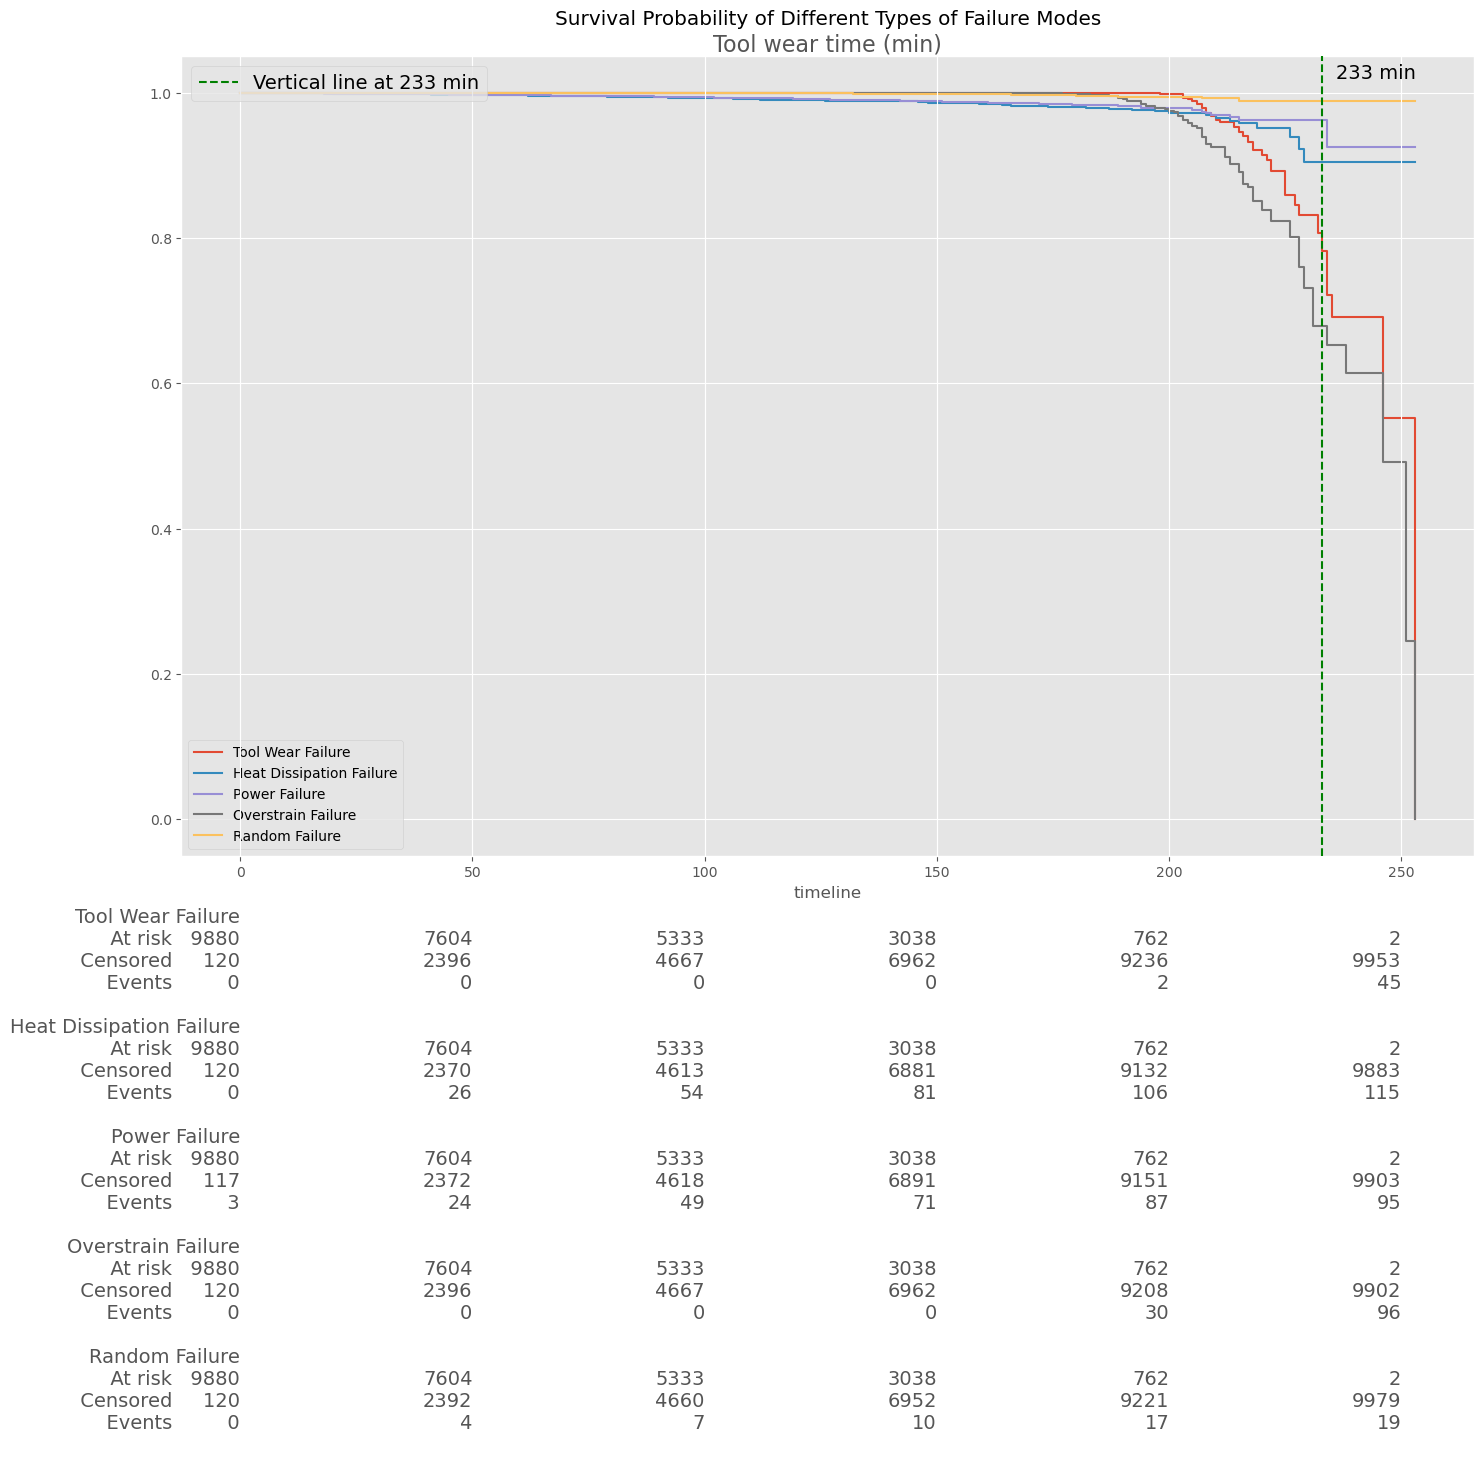

In [88]:
from lifelines.plotting import add_at_risk_counts
fig, ax = plt.subplots(figsize=(15, 15))

twf = df.drop(['HDF', 'PWF', 'OSF', 'RNF'], axis = 1)
hdf = df.drop(['TWF', 'PWF', 'OSF', 'RNF'], axis = 1)
pwf = df.drop(['TWF', 'HDF', 'OSF', 'RNF'], axis = 1)
osf = df.drop(['TWF', 'HDF', 'PWF', 'RNF'], axis = 1)
rnf = df.drop(['TWF', 'HDF', 'PWF', 'OSF'], axis = 1)

kmf_twf = KaplanMeierFitter()
kmf_twf.fit(twf['tool_wear_min'], event_observed=twf['TWF'], label="Tool Wear Failure")
kmf_twf.plot_survival_function(ax=ax, ci_show=False)

kmf_hdf = KaplanMeierFitter()
kmf_hdf.fit(hdf['tool_wear_min'], event_observed=hdf['HDF'], label="Heat Dissipation Failure")
kmf_hdf.plot_survival_function(ax=ax, ci_show=False)

kmf_pwf = KaplanMeierFitter()
kmf_pwf.fit(pwf['tool_wear_min'], event_observed=pwf['PWF'], label="Power Failure")
kmf_pwf.plot_survival_function(ax=ax, ci_show=False)

kmf_osf = KaplanMeierFitter()
kmf_osf.fit(osf['tool_wear_min'], event_observed=osf['OSF'], label="Overstrain Failure")
kmf_osf.plot_survival_function(ax=ax, ci_show=False)

kmf_rnf = KaplanMeierFitter()
kmf_rnf.fit(rnf['tool_wear_min'], event_observed=rnf['RNF'], label="Random Failure")
kmf_rnf.plot_survival_function(ax=ax, ci_show=False)

add_at_risk_counts(kmf_twf, kmf_hdf, kmf_pwf, kmf_osf,kmf_rnf, ax=ax)

# Increase label size
plt.xlabel('Tool wear time (min)', fontsize=16)
plt.ylabel('Survival probability', fontsize=16)
plt.title("Survival Probability of Different Types of Failure Modes", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Plot vertical line at 233 min
plt.axvline(x=233, color='green', linestyle='--', linewidth=1.5, label='Vertical line at 233 min')
plt.text(236,1.02,'233 min', fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.title("Survival Probability of Different Types of Failure Modes");

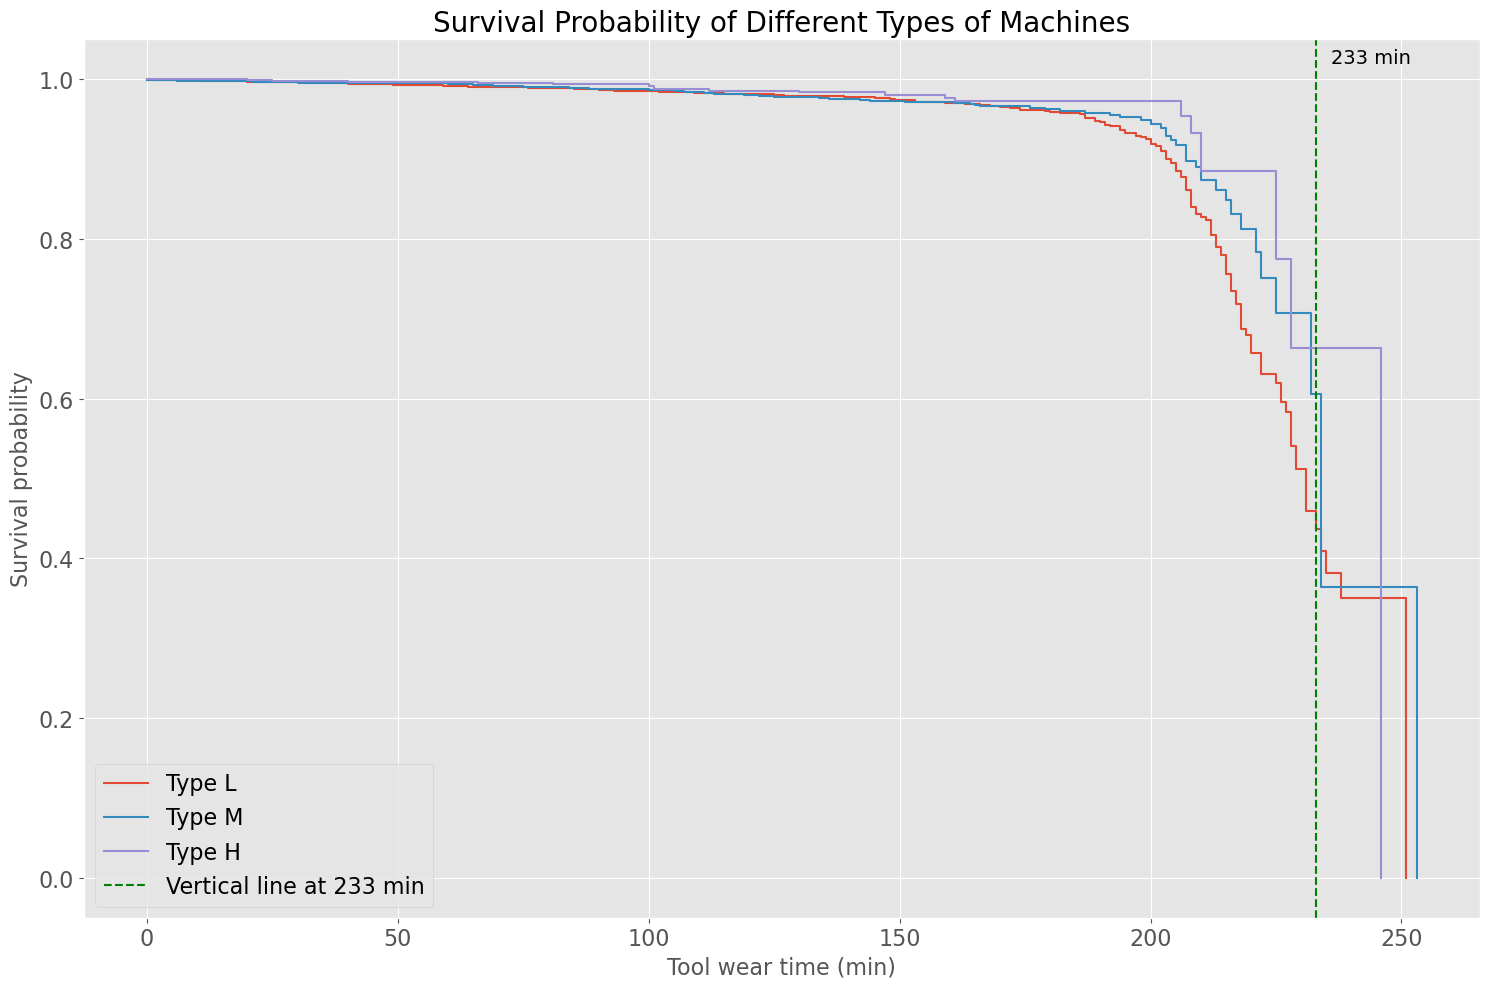

In [89]:
fig, ax = plt.subplots(figsize=(15, 10))

low = df[df['type'] == 0]
med = df[df['type'] == 1]
high = df[df['type'] == 2]

kmf = KaplanMeierFitter()
kmf.fit(low['tool_wear_min'], event_observed=low['machine_failure'], label="Type L")
kmf.plot_survival_function(ax=ax, ci_show=False)

kmf = KaplanMeierFitter()
kmf.fit(med['tool_wear_min'], event_observed=med['machine_failure'], label="Type M")
kmf.plot_survival_function(ax=ax, ci_show=False)

kmf = KaplanMeierFitter()
kmf.fit(high['tool_wear_min'], event_observed=high['machine_failure'], label="Type H")
kmf.plot_survival_function(ax=ax, ci_show=False)

plt.axvline(x=233, color='green', linestyle='--', linewidth=1.5, label='Vertical line at 233 min')
plt.text(236,1.02,'233 min', fontsize=14)
plt.xlabel('Tool wear time (min)', fontsize=16)  # Increase label size
plt.ylabel('Survival probability', fontsize=16)  # Increase label size
plt.title("Survival Probability of Different Types of Machines", fontsize=20)  # Increase title size
plt.xticks(fontsize=16)  # Increase tick label size
plt.yticks(fontsize=16)  # Increase tick label size
plt.legend(fontsize=16)  # Increase legend label size
plt.tight_layout()

Machines have a higher probability of damage after exceeding 233 minutes, whether on type L, M or H machines. The company can arrange a scheduled maintenance schedule for these machines. By carrying out regular maintenance before that time, companies can reduce the risk of damage and extend the service life of the machine. Machines that experience HDF, PWF and RNF damage appear to have a high survival probability when usage exceeds 250 minutes. In other words, companies must be more vigilant when machines are identified as experiencing TWF and OSF damage.

# Manually Calculating Survival Probabilities

In [10]:
# Step 1: Sort the observed event times
sorted_event_times = np.sort(df['tool_wear_min'].unique())

# Step 2: Initialize survival probability
survival_prob = np.array([1.0])

# Step 3: Iterate through the sorted event times
at_risk = []
events = []

for time in sorted_event_times:
    # Number of individuals at risk
    n_at_risk = len(df[df['tool_wear_min'] >= time])

    # Number of observed events
    n_events = df[(df['tool_wear_min'] == time) & (df['machine_failure'] == 1)]['machine_failure'].sum()

    # Append values to lists
    at_risk.append(n_at_risk)
    events.append(n_events)

    # Calculate survival probability
    prob_not_event = (n_at_risk - n_events) / n_at_risk
    survival_prob = np.append(survival_prob, survival_prob[-1] * prob_not_event)

# Step 4: Create DataFrame with the results
df_survival = pd.DataFrame({
    'Time': sorted_event_times,
    'At Risk': at_risk,
    'Events': events,
    'Survival Probability': survival_prob[:-1]
})

# Reset index
df_survival.reset_index(drop=True, inplace=True)
df_survival.head(15)

,Time,At Risk,Events,Survival Probability
0,0,10000,3,1.000000
1,2,9880,2,0.999700
2,3,9811,1,0.999498
3,4,9777,0,0.999396
4,5,9743,1,0.999396
5,6,9680,2,0.999293
6,7,9649,0,0.999087
7,8,9591,2,0.999087
8,9,9555,1,0.998878
9,10,9500,2,0.998774


In [11]:
df_survival[df_survival["Time"] == 210]

,Time,At Risk,Events,Survival Probability
209,210,394,5,0.856331


In [61]:
# Create a line chart
fig = go.Figure()

# Add a line trace
fig.add_trace(go.Scatter(x=df_survival['Time'], y=df_survival['Survival Probability'], mode='lines+markers', 
                         marker=dict(symbol='circle', size=10), line=dict(width=3)))

# Add axis labels and title
fig.update_layout(
    xaxis_title='Time',
    yaxis_title='Survival Probability',
    title='Survival Probability Manual Calculation',
    width=1000,
    height=600,
    title_x=0.5,
    title_xanchor='center',
    font=dict(
        size=18 
    )
)

# Show the plot
fig.show()

In [13]:
df[df['tool_wear_min'] > 233].describe()

,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,TWF,HDF,PWF,OSF,RNF,type,process_temperature_c,air_temperature_c
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.0,26.000000,26.000000,26.0,26.000000,26.000000,26.000000
mean,1550.461538,39.965385,240.346154,0.346154,0.192308,0.0,0.038462,0.192308,0.0,0.576923,37.407692,27.384615
std,160.134751,11.107149,5.268338,0.485165,0.401918,0.0,0.196116,0.401918,0.0,0.808608,1.437546,2.102939
min,1262.000000,23.000000,234.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,34.650000,23.550000
25%,1456.250000,30.800000,235.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,36.350000,25.950000
50%,1514.000000,40.700000,240.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,37.150000,27.450000
75%,1639.250000,46.225000,244.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,39.150000,29.625000
max,1923.000000,70.500000,253.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,2.000000,39.250000,30.150000


In [14]:
df[df['tool_wear_min'] <= 233].describe()

,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,TWF,HDF,PWF,OSF,RNF,type,process_temperature_c,air_temperature_c
count,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000
mean,1538.745639,39.986966,107.605875,0.033086,0.004111,0.011530,0.009425,0.009324,0.001905,0.500100,36.854121,26.853549
std,179.337520,9.966417,63.376081,0.178870,0.063986,0.106762,0.096626,0.096116,0.043606,0.670944,1.483654,1.999912
min,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.550000,22.150000
25%,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.650000,25.150000
50%,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.950000,26.950000
75%,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,37.950000,28.350000
max,2886.000000,76.600000,233.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,40.650000,31.350000


# **Random Survival Forest**

In [15]:
x = df[['type', 'air_temperature_c','process_temperature_c','rotational_speed_rpm','torque_nm','tool_wear_min']]
y = df.machine_failure

print("Number of new samples before resampling: ", len(x))
print(y.value_counts())

Number of new samples before resampling:  10000
machine_failure
0    9661
1     339
Name: count, dtype: int64


In [16]:
# Fix class imbalance in the dataset
from imblearn.over_sampling import SMOTE

# Initialize SMOTE object
smote = SMOTE(sampling_strategy=0.8, random_state=50)

# Resample with SMOTE
x_resampled, y_resampled = smote.fit_resample(x, y)

print("Number of new samples after resampling: ", len(x_resampled))
print(y_resampled.value_counts())

Number of new samples after resampling:  17389
machine_failure
0    9661
1    7728
Name: count, dtype: int64


In [17]:
# Rename columns
cols = list(x.columns)
df_resampled = pd.DataFrame(x_resampled, columns=cols)
df_resampled['failure'] = y_resampled

df_resampled.head()

,type,air_temperature_c,process_temperature_c,rotational_speed_rpm,torque_nm,tool_wear_min,failure
0,1,24.95,35.45,1551,42.8,0,0
1,0,25.05,35.55,1408,46.3,3,0
2,0,24.95,35.35,1498,49.4,5,0
3,0,25.05,35.45,1433,39.5,7,0
4,0,25.05,35.55,1408,40.0,9,0


In [18]:
X = df_resampled.drop(['tool_wear_min', 'failure'], axis = 1)
T = df_resampled[['failure', 'tool_wear_min']]

T.head()

,failure,tool_wear_min
0,0,0
1,0,3
2,0,5
3,0,7
4,0,9


In [19]:
from sklearn.model_selection import train_test_split

# Perform train-test split
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2, random_state=42)

# Verify the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("T_train shape:", T_train.shape)
print("T_test shape:", T_test.shape)

T_test.head()

X_train shape: (13911, 5)
X_test shape: (3478, 5)
T_train shape: (13911, 2)
T_test shape: (3478, 2)


,failure,tool_wear_min
13438,1,212
4999,0,32
13444,1,188
6888,0,118
6806,0,119


In [20]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv

rsf = RandomSurvivalForest(n_estimators=100, max_features="sqrt", max_depth=5, min_samples_leaf=20)
T_train_surv = Surv.from_dataframe('failure', 'tool_wear_min', T_train)
T_test_surv = Surv.from_dataframe('failure', 'tool_wear_min', T_test)
rsf.fit(X_train, T_train_surv)

#### Cross Validation / Model Performances
times = np.arange(251)
rsf_surv_prob = np.row_stack([fn(times) for fn in rsf.predict_survival_function(X_test)])
c_index = concordance_index_censored(T_test_surv['failure'], T_test_surv['tool_wear_min'], rsf.predict(X_test))
print('C-index: {:.2f}'.format(c_index[0]))

ibs = integrated_brier_score(T_train_surv, T_test_surv, rsf_surv_prob, times)
print('IBS: {:.2f}'.format(ibs))

C-index: 0.87
IBS: 0.07


The C-index (concordance index) is a measure of the accuracy of a model in predicting the risk of a specific event, such as machine damage. It ranges from 0 to 1, with a higher value indicating better accuracy. A C-index of 0.80 or higher is considered to be good, indicating that the model is able to correctly predict the risk of machine damage in most cases.

The IBS (integrated Brier score) is a measure of the calibration of a model, which assesses how well the predicted probabilities of an event match the observed frequencies of that event. A lower IBS value indicates better calibration, meaning that the model is not overestimating or underestimating the risk of machine damage. An IBS of 0.07 is considered to be low, indicating that the model is well-calibrated.

In [62]:
from sksurv.nonparametric import kaplan_meier_estimator

# Calculate the combined actual survival curve using Kaplan-Meier estimator
time_points, actual_survival_prob = kaplan_meier_estimator(T_test['failure'].astype(bool), T_test['tool_wear_min'])

# Predicted survival counts
predicted_survival_counts = (rsf_surv_prob.sum(axis=0)).astype(int)

# Create a Plotly figure
fig = go.Figure()

# Add the actual survival curve
fig.add_trace(go.Scatter(x=time_points, y=actual_survival_prob * len(T_test), mode='lines', 
                         name="Combined Actual", line=dict(width=3)))

# Add the predicted survival counts
fig.add_trace(go.Scatter(x=time_points, y=predicted_survival_counts, mode='lines', 
                         name="Predicted Survival Counts", line=dict(width=3)))

# Update layout with axis labels and title
fig.update_layout(
    xaxis_title='Time',
    yaxis_title='Survival Count',
    title='Combined Actual vs Predicted Survival Curves',
    width=1000,
    height=600,
    title_x=0.5,
    title_xanchor='center',
    font=dict(
        size=18 
    )
)

# Show the plot
fig.show()

# 5 sample testing

In [123]:
np.random.seed(5)
filtered_indices = np.where(T_test['failure'] == 1)[0]
random_indices = np.random.choice(filtered_indices, size=5, replace=False)
random_samples = X_test.iloc[random_indices]
time_samples = T_test.iloc[random_indices]

samples = pd.concat([random_samples, time_samples], axis=1)

samples

,type,air_temperature_c,process_temperature_c,rotational_speed_rpm,torque_nm,failure,tool_wear_min
16537,0,28.100322,37.349742,1302,59.449205,1,199
16864,0,28.667049,37.791476,1441,43.902034,1,208
11275,1,28.699187,36.985670,1287,66.036794,1,107
15345,0,28.945360,37.439751,1369,44.815097,1,85
12823,0,27.237706,38.266097,2047,20.149175,1,224


In [140]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def plot_survival_curve(testing_data, title, tool_wear_min):
    survival = rsf.predict_survival_function(testing_data, return_array=True).flatten()
    risk = rsf.predict(testing_data)
    risk_scores.append(risk)
    times = np.arange(len(survival))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=times, y=survival, mode='lines', name='Survival Curve'))
    thresholds = [0.6, 0.4, 0.2]
    colors = ['green', 'orange', 'red']
    labels = ['Low Risk Fail', 'Medium Risk Fail', 'High Risk Fail']
    for threshold, color, label in zip(thresholds, colors, labels):
        exceeds_threshold = np.where(survival > threshold)[0]
        if len(exceeds_threshold) > 0:
            max_exceeds_threshold = exceeds_threshold[-1]
            annotate_time = times[max_exceeds_threshold]
            fig.add_vline(x=annotate_time, line_color=color, line_dash='dash', annotation_text=f'{annotate_time}')
            fig.add_annotation(x=annotate_time, y=threshold, text=label, showarrow=True, arrowhead=1)
    
    # Add a dot to show the tool_wear_min
    fig.add_trace(go.Scatter(x=[tool_wear_min], y=[survival[tool_wear_min]], mode='markers', marker=dict(color='black', size=7), name='Tool Wear (min)'))

    fig.update_layout(
        title=f'{title}',
        xaxis_title='Time',
        yaxis_title='Survival Probability',
        yaxis_range=[0, 1.05],
        title_x=0.5,
        title_xanchor='center',
        width=900,
        font=dict(
            size=18 
        )
    )
    fig.show()

    threshold_times = []
    for threshold in thresholds:
        exceeds_threshold = np.where(survival > threshold)[0]
        if len(exceeds_threshold) > 0:
            max_exceeds_threshold = exceeds_threshold[-1]
            annotate_time = times[max_exceeds_threshold]
            threshold_times.append(annotate_time)
        else:
            threshold_times.append(None)
    return threshold_times

# Create a list to collect the annotated times for each row
annotated_times = []

# Drop the index from time_samples
reindexed_time_samples = time_samples.reset_index(drop=True)

# Create a list for the risk scores
risk_scores = []

# Iterate over the rows in random_samples
for i, (_, row) in enumerate(random_samples.iterrows()):
    testing_data = np.array([row])  # Convert the row to a 2D array for prediction']
    title = f"Sample {row.name}"  # Set the title for each sample plot
    tool_wear_min = reindexed_time_samples.loc[i, 'tool_wear_min']  # Get the tool_wear_min value for each sample
    threshold_times = plot_survival_curve(testing_data, title, tool_wear_min)
    annotated_times.append(threshold_times)

# Create the DataFrame from the collected annotated times
df_annotated_times = pd.DataFrame(annotated_times, columns=['Low Risk', 'Medium Risk', 'High Risk'])
df_annotated_times = df_annotated_times.set_index(samples.index)  # Set the index to match 'samples'

# Merge the 'samples' DataFrame and 'df_annotated_times' DataFrame based on their indices
samples_predicted = pd.merge(samples, df_annotated_times, left_index=True, right_index=True)
samples_predicted

,type,air_temperature_c,process_temperature_c,rotational_speed_rpm,torque_nm,failure,tool_wear_min,Low Risk,Medium Risk,High Risk
16537,0,28.100322,37.349742,1302,59.449205,1,199,158,192,203
16864,0,28.667049,37.791476,1441,43.902034,1,208,211,218,227
11275,1,28.699187,36.985670,1287,66.036794,1,107,87,114,181
15345,0,28.945360,37.439751,1369,44.815097,1,85,84,146,199
12823,0,27.237706,38.266097,2047,20.149175,1,224,212,219,226


In [151]:
# Calculate the absolute differences between 'tool_wear_min' and risk columns
diff_low = abs(samples_predicted['tool_wear_min'] - samples_predicted['Low Risk'])
diff_medium = abs(samples_predicted['tool_wear_min'] - samples_predicted['Medium Risk'])
diff_high = abs(samples_predicted['tool_wear_min'] - samples_predicted['High Risk'])

# Create a new column 'Risk Type' based on the smallest difference
samples_predicted['Risk Type (Tool Wear Time)'] = ''
samples_predicted.loc[diff_low <= diff_medium, 'Risk Type (Tool Wear Time)'] += 'Low'
samples_predicted.loc[(diff_medium < diff_low) & (diff_medium < diff_high), 'Risk Type (Tool Wear Time)'] += 'Medium'
samples_predicted.loc[(diff_high < diff_low) & (diff_high < diff_medium), 'Risk Type (Tool Wear Time)'] += 'High'

# Handle cases with the same or smaller differences between risk types
# samples_predicted.loc[(diff_low == diff_medium) | ((diff_low <= 10) & (diff_medium <= 10)), 'Risk Type'] = 'Low-Medium'
# samples_predicted.loc[(diff_high == diff_medium) | ((diff_high <= 10) & (diff_medium <= 10)), 'Risk Type'] = 'Medium-High'

samples_predicted['Risk Type (Tool Wear Time)'] += ' Risk'

# Round risk scores to two decimal places
rounded_risk_scores = np.round(risk_scores, 2)

# Add Overall Risk Score using risk_scores
samples_predicted['Overall Risk Score'] = rounded_risk_scores

samples_predicted.drop(['failure', 'Low Risk', 'Medium Risk', 'High Risk'], axis=1)

,type,air_temperature_c,process_temperature_c,rotational_speed_rpm,torque_nm,tool_wear_min,Risk Type (Tool Wear Time),Overall Risk Score
16537,0,28.100322,37.349742,1302,59.449205,199,High Risk,275.12
16864,0,28.667049,37.791476,1441,43.902034,208,Low Risk,98.22
11275,1,28.699187,36.985670,1287,66.036794,107,Medium Risk,397.79
15345,0,28.945360,37.439751,1369,44.815097,85,Low Risk,352.54
12823,0,27.237706,38.266097,2047,20.149175,224,High Risk,97.28


We categorize the risk as follows:
- Low risk: Survival probability ≤ 0.6
- Medium risk: Survival probability ≤ 0.4
- High risk: Survival probability ≤ 0.2